In [19]:
import torch
from torch import nn
from torchdiffeq import odeint
from torch.nn.parameter import Parameter
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal

from reggae.gp.variational.models import SingleLinearLFM
from reggae.gp.variational.trainer import Trainer
from reggae.data_loaders import load_barenco_puma, DataHolder, scaled_barenco_data
from reggae.utilities import softplus, inv_softplus, cholesky_inverse
from reggae.plot.variational_plotters import Plotter
from matplotlib import pyplot as plt

import numpy as np

f64 = np.float64

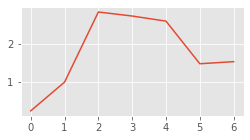

In [21]:
replicate = 0 #TODO: for now we are just considering the first replicate

m_observed, f_observed, σ2_m_pre, σ2_f_pre, t = load_barenco_puma('../data/')

m_df, m_observed = m_observed
f_df, f_observed = f_observed
# Shape of m_observed = (replicates, genes, times)
m_observed = torch.tensor(m_observed)[replicate]

σ2_m_pre = f64(σ2_m_pre)
σ2_f_pre = f64(σ2_f_pre) #not used

num_genes = m_observed.shape[0]
num_tfs = 1

t_inducing = torch.linspace(f64(0), f64(1), 5, dtype=torch.float64).reshape((-1, 1))
t_observed = torch.linspace(f64(0), f64(1), 7)
plt.figure(figsize=(4, 2))
plt.plot(m_observed[0])

In [22]:
def save(name):
    torch.save(model.state_dict(), f'{name}.pt')

def load(model_class):
    model = SingleLinearLFM(num_genes, num_tfs, t_inducing)
    model.load_state_dict(torch.load('model.pt'))
    return model

def plot_genes(rtol=1e-4, atol=1e-6):
    t_predict = torch.linspace(f64(0), f64(1), 80)
    initial_value = torch.zeros((num_genes, 1), dtype=torch.float64) #, dtype=torch.float64

    # output_obs, _ = model(t_observed.view(-1), initial_value, rtol=rtol, atol=atol)
    # output_obs = torch.squeeze(output_obs).detach()
    # plt.plot(t_observed, output_obs[0])
    # plt.scatter(t_observed, m_observed[0][0])

    outputs, _ = model(t_predict.view(-1), initial_value, rtol=rtol, atol=atol, num_samples=1)

    outputs = torch.squeeze(outputs)
    print(outputs.shape)
    plt.figure(figsize=(5, 8))
    for i in range(num_genes):
        plt.subplot(511+i)
        plt.plot(t_predict, torch.squeeze(outputs[i]).detach())
        plt.scatter(t_observed, m_observed[i])

def plot_tfs(ylim=(-2, 2), num_samples=7, plt_inducing=False):
    tf_i = 0

    t_predict = torch.linspace(0, 1, 80)
    q_f = model.get_tfs(t_predict.reshape(-1))
    q_u = model.get_tfs(model.inducing_inputs)
    mean = model.G(q_f.mean).detach().numpy() # (T)
    mean_u = model.G(q_u.mean).detach().numpy()
    std = torch.sqrt(q_f.variance)[tf_i].detach().numpy()
    std_u = torch.sqrt(q_u.variance[0]).detach().numpy()
    barenco_f, _ = scaled_barenco_data(mean)
    plt.figure(figsize=(5, 3))
    plt.fill_between(t_predict, mean+std, mean-std, color='orangered', alpha=0.5)
    plt.scatter(np.linspace(0,1,7), barenco_f, marker='x', s=60, linewidth=2, label='Barenco et al.')
    plt.scatter(t_inducing, mean_u, marker='o', color='brown')
    for _ in range(num_samples):
        plt.plot(t_predict, model.G(q_f.sample()).detach(), alpha=0.2, color='gray')
    plt.plot(t_predict, mean, color='gray')

    if plt_inducing:
        S = torch.matmul(model.q_cholS, model.q_cholS.transpose(1,2))
        std_u = torch.sqrt(torch.diagonal(S[0])).detach()
        u = torch.squeeze(model.q_m[tf_i].detach())
        print(std_u, u.shape, model.q_m.shape)
        plt.plot(t_inducing, u)
        plt.fill_between(t_inducing.view(-1), u+std_u, u-std_u, color='green', alpha=0.5)

    plt.title('Latent')
    plt.ylim(ylim)


In [23]:
model = SingleLinearLFM(num_genes, num_tfs, t_inducing, known_variance=σ2_m_pre[0])
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
trainer = Trainer(model, optimizer, (t_observed, m_observed))

# list(model.parameters())

C:\Users\Jacob\Documents\proj\reggae\reggae\gp\variational\models.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inducing_inputs = torch.tensor(t_inducing, requires_grad=False)


### Outputs prior to training:

C:\Users\Jacob\Documents\proj\reggae\reggae\plot\variational_plotters.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(plotnum)


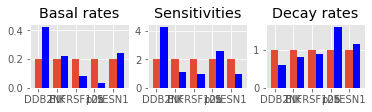

In [24]:
plotter = Plotter(model, m_df.index)
plotter.plot_kinetics()

torch.Size([5, 80])


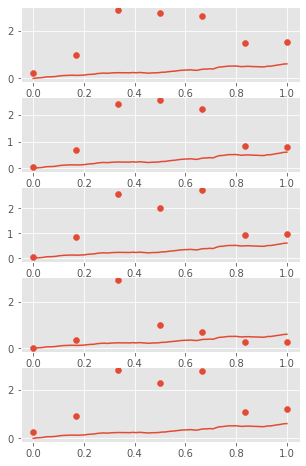

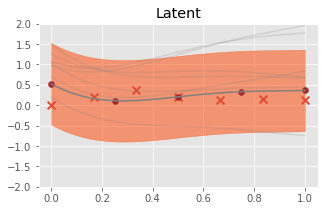

In [25]:
plot_genes(rtol=1e-3, atol=1e-4)
plot_tfs()

Epoch 16/30 - Loss: 228.92 (215.93 12.99) [1.90,0.54,-0.41] b: 1.27 d 1.28 s 2.90 λ: 0.231
Epoch 17/30 - Loss: 225.94 (213.79 12.14) [1.99,0.54,-0.48] b: 1.29 d 1.32 s 2.96 λ: 0.209
Epoch 18/30 - Loss: 223.66 (212.65 11.01) [2.09,0.54,-0.54] b: 1.32 d 1.34 s 3.02 λ: 0.191
Epoch 19/30 - Loss: 211.60 (201.48 10.12) [2.17,0.54,-0.60] b: 1.35 d 1.36 s 3.08 λ: 0.176
Epoch 20/30 - Loss: 200.13 (190.69 9.45) [2.24,0.54,-0.67] b: 1.37 d 1.38 s 3.11 λ: 0.163
Epoch 21/30 - Loss: 212.84 (203.91 8.93) [2.31,0.54,-0.73] b: 1.39 d 1.39 s 3.14 λ: 0.153
Epoch 22/30 - Loss: 212.75 (204.23 8.52) [2.36,0.55,-0.79] b: 1.40 d 1.41 s 3.15 λ: 0.143
Epoch 23/30 - Loss: 246.89 (238.70 8.20) [2.40,0.55,-0.84] b: 1.41 d 1.42 s 3.14 λ: 0.135
Epoch 24/30 - Loss: 196.66 (188.72 7.94) [2.44,0.55,-0.89] b: 1.43 d 1.43 s 3.12 λ: 0.128
Epoch 25/30 - Loss: 226.98 (219.13 7.86) [2.47,0.56,-0.94] b: 1.44 d 1.44 s 3.09 λ: 0.127
Epoch 26/30 - Loss: 207.24 (199.40 7.84) [2.49,0.57,-0.97] b: 1.45 d 1.43 s 3.04 λ: 0.127
Epoch 

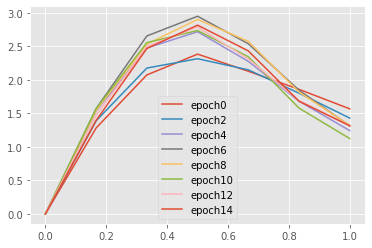

In [27]:
tol = 1e-3
# trainer = Trainer(optimizer)
output = trainer.train(15, rtol=tol, atol=tol/10, report_interval=1, plot_interval=2)

### Outputs after training

torch.Size([5, 80])


C:\Users\Jacob\Documents\proj\reggae\reggae\plot\variational_plotters.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(plotnum)


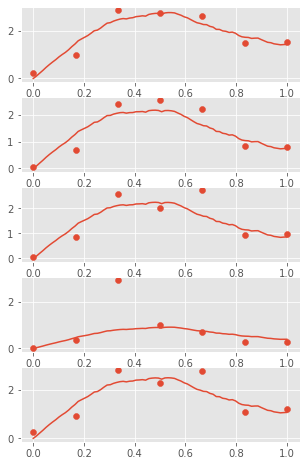

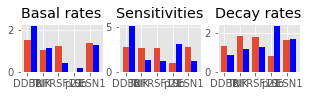

In [28]:
tol = 1e-3
plotter = Plotter(model, m_df.index)

# plot_losses(trainer)
plot_genes(rtol=tol, atol=tol/10)
plot_tfs(ylim=(-2, 3))
plotter.plot_kinetics()

In [29]:
save('variational_linear')

In [260]:
model = load(SingleLinearLFM)
optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
trainer = Trainer(optimizer)

C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
plt.figure(figsize=(5, 6))
basals = np.array(trainer.basalrates)
decays = np.array(trainer.decayrates)
lengthscales = np.array(trainer.lengthscales)
print(lengthscales.shape)
plt.subplot(311)
# print(basals[:,0])
plt.plot(basals[:,0])
# plt.ylim(1, 1.5)
plt.subplot(312)
plt.plot(decays[:,0])
# plt.ylim(0.5, 1)
plt.subplot(313)
plt.plot(lengthscales)
# plt.ylim(1, 1.2)

print(model.basal_rate)


In [217]:
model.sensitivity
model.decay_rate
# model.gp.covar_module.outputscale

Parameter containing:
tensor([[0.9056],
        [1.5209],
        [1.2982],
        [0.8000],
        [1.1355]], dtype=torch.float64, requires_grad=True)